## Name: {Claire Zhou}
## Section: {02}

# Lab 9: Feature Importance

In this lab we will go through some simple ways of doing feature importance using either the built-in methods or through permutation. 

## Tools

#### Libraries:

- numpy: for processing
- sklearn: for model training and feature importances
- pandas: for data processing  

#### Datasets:

Boston housing 

## Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance

from types import SimpleNamespace
def load_boston(return_X_y=False):
    """Replacement function for loading in Boston House Prices"""
    df = pd.read_csv('boston_house_prices.csv')
    X = df.drop(columns=['MEDV'])
    y = df['MEDV'].to_numpy()

    if return_X_y:
        return X, y 
    
    dataset  = SimpleNamespace(data=X, target=y)
    
    return dataset

In [2]:
def boston():
    boston = load_boston()
    df = boston.data
    y = boston.target
    df['y'] = y
    return df

df_boston = boston()
X, y = df_boston.drop('y', axis=1), df_boston['y']
y *= 1000
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Linear Models

First let's train a Lasso regression model and visualize the size of the coefficients to get something that looks like a standard feature importance bar chart.

In [4]:
# first let's rescale our data
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(X_train)

lmbda = .1

lm = Lasso(alpha=lmbda, tol=.1)
lm.fit(x_train_sc, y_train)

# extract the coefficients
importance = abs(lm.coef_)

importance

array([ 987.31597096,  866.28147376,  403.84054093,  862.17796801,
       1898.79466096, 2808.99594299,  359.32850932, 3044.0570321 ,
       2026.56212439, 1358.87610007, 2082.07762449, 1041.1253087 ,
       3925.79685013])

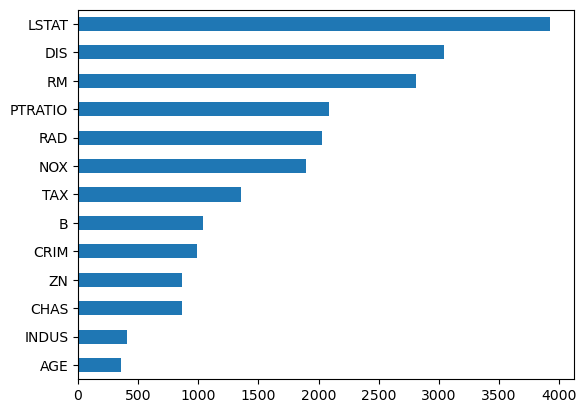

In [5]:
feat_importances = pd.Series(importance, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

We see in the plot above that LSTAT, RM, and DIS had the largest coefficients. For a regularized model, where the features have been normalized, the size of the coefficients can be an indicator of feature importance. We will see how much these agree with our other feature importance metrics below.

---
## Decision Tree

Now let's fit a simple decision tree and take a look at the feature importances it produces. To see which method it is using for importances you can look [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.feature_importances_).

In [6]:
tr_model = DecisionTreeRegressor()
tr_model.fit(X_train, y_train)

# extract feature importances and sort
importance = tr_model.feature_importances_

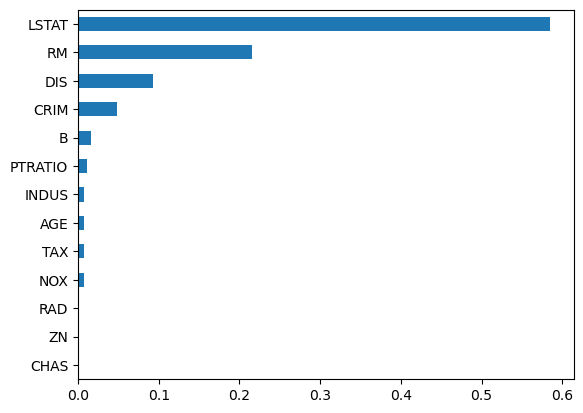

In [7]:
feat_importances = pd.Series(importance, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

---
**Q.** What were the most important features from the decision tree, and which method was used to create those feature importances?

### LSAT, RM, DIS, CRIM and B were the top 5 most important features. Gini impurity was used to create the feature importances.

## Permutation Importance

We can specifically create feature importances using the permutation importance method by using `permutation_importance` from sklearn.

In [8]:
p_importance = permutation_importance(tr_model, X_train, y_train, n_repeats=25, random_state=12)

p_importances = p_importance.importances_mean

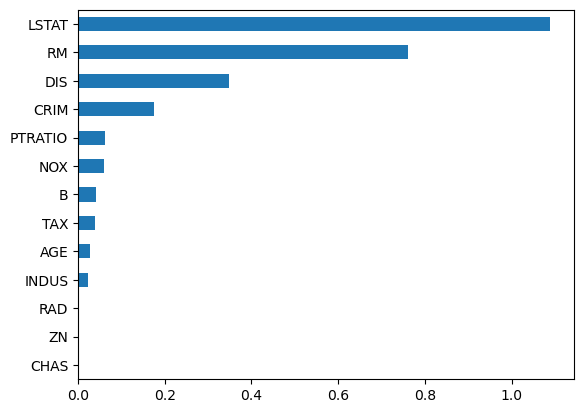

In [9]:
feat_importances = pd.Series(p_importances, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

---

**Q.** What have you noticed about the important features using each of the different methods above?

### The top four features are aligned for GINI and permutation methods. These 4 are also where the importances are very strong and much more higher than the rest of the features. There are variations in the ranking of the other mild features. 

---
## Random Forest

When we run the random forest we get a gini-based set of feature importances, so if we want permutation-based importances we have to specifically use the `permutation_importance()` function.

In [10]:
rf = RandomForestRegressor(n_estimators=30)
rf.fit(X_train, y_train)

p_importance = permutation_importance(rf, X_train, y_train, n_repeats=25, random_state=12)

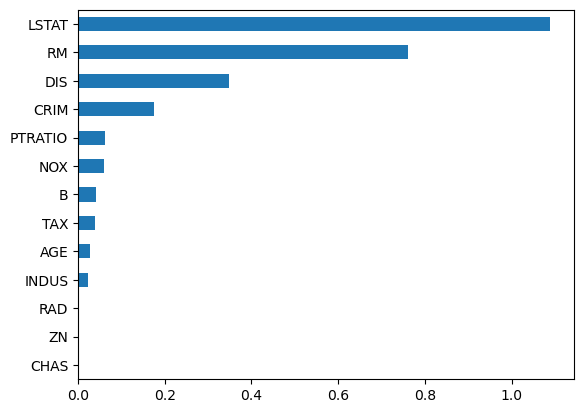

In [11]:
feat_importances = pd.Series(p_importances, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

Again, we are seeing a lot of agreement between our methods and models, which is nice. Below, just for completeness, let's extract the gini-based feature importances and take a look at them.

In [12]:
rf.feature_importances_

array([0.02971205, 0.00335045, 0.0079494 , 0.00078929, 0.0101851 ,
       0.34397289, 0.01394925, 0.05428284, 0.00879674, 0.01225537,
       0.02075196, 0.01412286, 0.47988178])

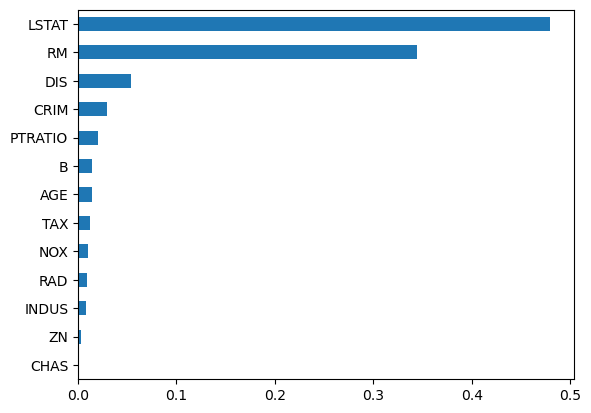

In [13]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

---
## Noise Column

Let's make sure these methods are actually working by adding a single column of noise to our training data and checking the importances. 

In [14]:
X_train['noise'] = np.random.uniform(size = len(X_train))

tr_model = DecisionTreeRegressor()
tr_model.fit(X_train, y_train)

p_importance = permutation_importance(tr_model, X_train, y_train, n_repeats=25, random_state=12)
p_importances = p_importance.importances_mean

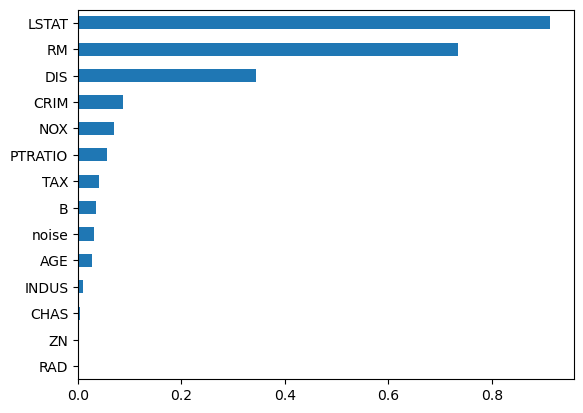

In [15]:
feat_importances = pd.Series(p_importances, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

Hopefully you see the noise feature somewhere near the bottom of the list. If we were to rerun it over and over again, we should see the noise feature bounce around a little, but near the bottom. 

**Q.** Explain why the noise feature is near the bottom of the list. Don't just say "because it's not important". Explain the mechanism behind why it gets such a low importance score.

### The permutation importance process involves randomly shuffling the values of each feature. In the case of the noise feature, its values are randomly rearranged across samples. The noise feature is created from random shuffling which does not have any relationship with the target and no impact on the model performance therefore it is near the bottom of the importance list. The average performance drop is used to rank the features. Since the noise feature consistently has a low average performance drop across multiple permutations, it ends up being ranked near the bottom of the list.

---
**Q.** Write a loop to train the random forest, calculate the permutation importances, and plot the bar chart 5 times and comment below and what you notice.

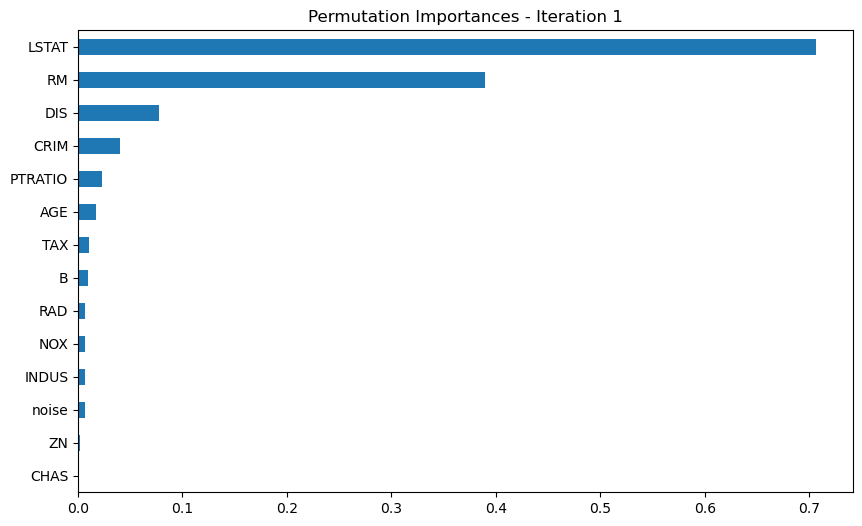

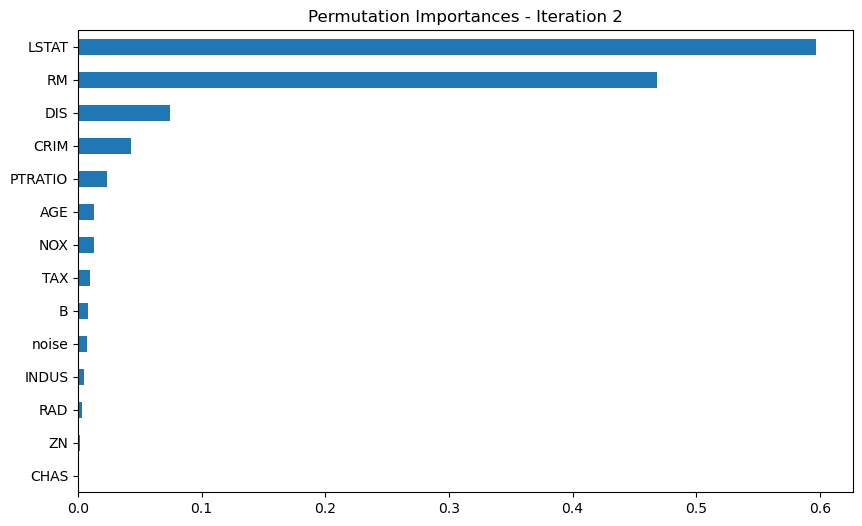

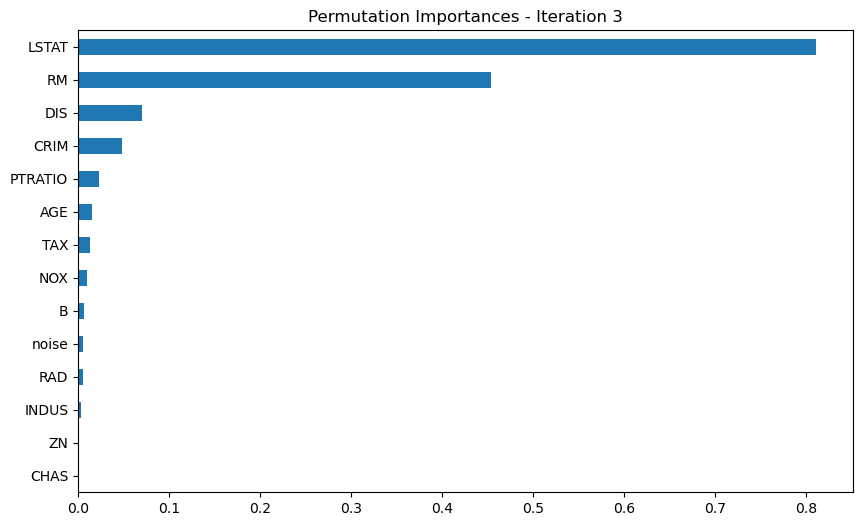

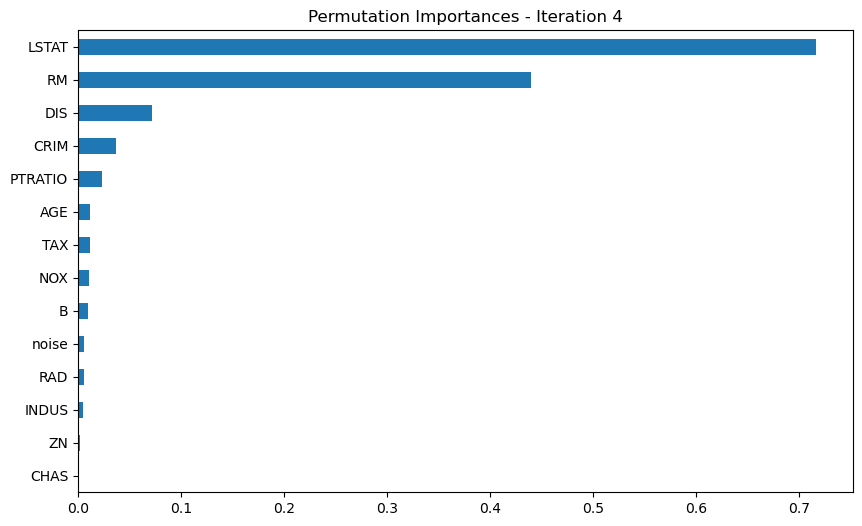

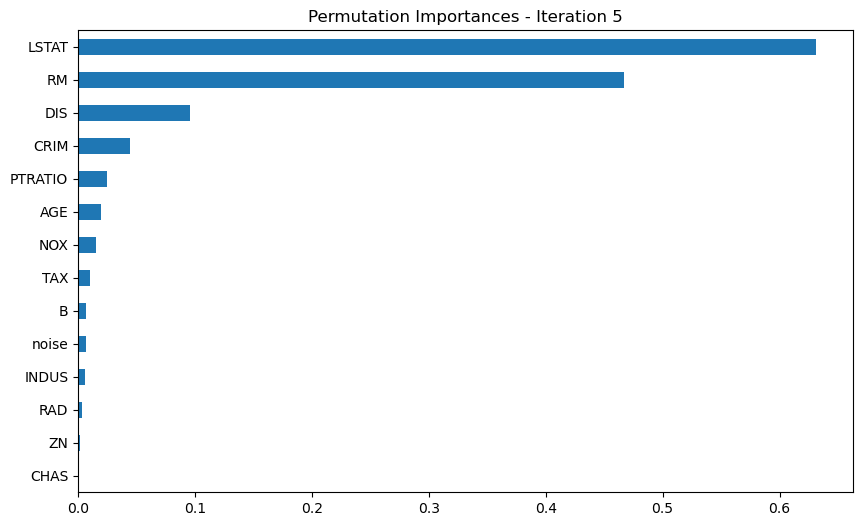

In [20]:
import matplotlib.pyplot as plt

for i in range(5):
    rf = RandomForestRegressor(n_estimators=30, random_state=i)
    rf.fit(X_train, y_train)
    
    p_importances = permutation_importance(rf, X_train, y_train, n_repeats=25, random_state=12)
    
    # Extract feature importances and create a Pandas Series
    feat_importances_i = pd.Series(p_importances.importances_mean, index=X_train.columns)
    
    plt.figure(figsize=(10, 6))
    feat_importances_i.nlargest(25).plot(kind='barh').invert_yaxis()
    plt.title(f'Permutation Importances - Iteration {i + 1}')
    plt.show()

### The top features and features below noise are pretty consistent.